The following ResNext network is trained for images size of 400x400 and with BAS added as a new classification target. The ratio of training set, validation set and test set is 6:1:3

In [1]:
from keras import layers
from keras import models


#
# image dimensions
#

img_height = 400
img_width = 400
img_channels = 3

#
# network params
#

cardinality = 32


def residual_network(x):
    """
    ResNeXt by default. For ResNet set `cardinality` = 1 above.
    
    """
    def add_common_layers(y):
        y = layers.BatchNormalization()(y)
        y = layers.LeakyReLU()(y)

        return y

    def grouped_convolution(y, nb_channels, _strides):
        # when `cardinality` == 1 this is just a standard convolution
        if cardinality == 1:
            return layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
        
        assert not nb_channels % cardinality
        _d = nb_channels // cardinality

        # in a grouped convolution layer, input and output channels are divided into `cardinality` groups,
        # and convolutions are separately performed within each group
        groups = []
        for j in range(cardinality):
            group = layers.Lambda(lambda z: z[:, :, :, j * _d:j * _d + _d])(y)
            groups.append(layers.Conv2D(_d, kernel_size=(3, 3), strides=_strides, padding='same')(group))
            
        # the grouped convolutional layer concatenates them as the outputs of the layer
        y = layers.concatenate(groups)

        return y

    def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _project_shortcut=False):
        """
        Our network consists of a stack of residual blocks. These blocks have the same topology,
        and are subject to two simple rules:

        - If producing spatial maps of the same size, the blocks share the same hyper-parameters (width and filter sizes).
        - Each time the spatial map is down-sampled by a factor of 2, the width of the blocks is multiplied by a factor of 2.
        """
        shortcut = y

        # we modify the residual building block as a bottleneck design to make the network more economical
        y = layers.Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        y = add_common_layers(y)

        # ResNeXt (identical to ResNet when `cardinality` == 1)
        y = grouped_convolution(y, nb_channels_in, _strides=_strides)
        y = add_common_layers(y)

        y = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        # batch normalization is employed after aggregating the transformations and before adding to the shortcut
        y = layers.BatchNormalization()(y)

        # identity shortcuts used directly when the input and output are of the same dimensions
        if _project_shortcut or _strides != (1, 1):
            # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
            # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
            shortcut = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        y = layers.add([shortcut, y])

        # relu is performed right after each batch normalization,
        # expect for the output of the block where relu is performed after the adding to the shortcut
        y = layers.LeakyReLU()(y)

        return y

    # conv1
    x = layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(x)
    x = add_common_layers(x)

    # conv2
    x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    for i in range(3):
        project_shortcut = True if i == 0 else False
        x = residual_block(x, 128, 256, _project_shortcut=project_shortcut)

    # conv3
    for i in range(4):
        # down-sampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 256, 512, _strides=strides)

    # conv4
    for i in range(6):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 512, 1024, _strides=strides)

    # conv5
    for i in range(3):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 1024, 2048, _strides=strides)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(5,activation='softmax')(x)

    return x


In [2]:
image_tensor = layers.Input(shape=(img_height, img_width, img_channels))
network_output = residual_network(image_tensor)

In [3]:
model = models.Model(inputs=[image_tensor], outputs=[network_output])
#print(model.summary())

In [4]:
import os
import cv2
from keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
import numpy as np

In [5]:
optimizer = Adam(learning_rate=1e-4)  # Using Adam instead of SGD to speed up training
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
print("Finished compiling")
print("Building model...")

Finished compiling
Building model...


In [6]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                               rotation_range=15,
                               width_shift_range=10./400,
                               height_shift_range=10./400,
                               horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255,
                               rotation_range=15,
                               width_shift_range=10./400,
                               height_shift_range=10./400,
                               horizontal_flip=True)

In [9]:
train_dir = '/content/drive/MyDrive/new_data_2/train'
validation_dir = '/content/drive/MyDrive/new_data_2/val'
all_classes = [str(i) for i in range(1, 6)]

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(400, 400), 
    batch_size=16,
    classes=all_classes,
    class_mode='categorical',
    shuffle=True)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 673 images belonging to 5 classes.


In [11]:
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(400, 400),
    batch_size=16,
    classes=all_classes,
    class_mode='categorical',
    shuffle=True)

Found 112 images belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


In [12]:
model_checkpoint = ModelCheckpoint('./models/best_model_ResNext_2.h5', monitor='val_loss',
                                   verbose=1, save_best_only=True)

In [13]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1),
                               cooldown=0, patience=10, min_lr=1e-6)

In [14]:
callbacks = [lr_reducer, model_checkpoint]

In [15]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=train_generator.samples // 16,
                              epochs=100,
                              verbose=1,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=validation_generator.samples // 16,
                              shuffle=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 0.8792 - accuracy: 0.6971
Epoch 1: val_loss improved from inf to 1.93456, saving model to ./models/best_model_ResNext_2.h5
42/42 [==============================] - 251s 5s/step - loss: 0.8792 - accuracy: 0.6971 - val_loss: 1.9346 - val_accuracy: 0.3571 - lr: 1.0000e-04
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 0.4650 - accuracy: 0.8341
Epoch 2: val_loss did not improve from 1.93456
42/42 [==============================] - 39s 927ms/step - loss: 0.4650 - accuracy: 0.8341 - val_loss: 3.1056 - val_accuracy: 0.3571 - lr: 1.0000e-04
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 0.4166 - accuracy: 0.8554
Epoch 3: val_loss did not improve from 1.93456
42/42 [==============================] - 42s 1s/step - loss: 0.4166 - accuracy: 0.8554 - val_loss: 4.3168 - val_accuracy: 0.3571 - lr: 1.0000e-04
Epoch 4/100
42/42 [==============================] - ETA: 0s - loss: 0.3879 - accu

In [16]:
%matplotlib inline

In [17]:
import matplotlib
matplotlib.rcParams['backend'] = "Qt4Agg"

In [18]:
def show_train_history(train_history,train_metrics,validation_metrics):
    plt.plot(train_history.history[train_metrics])
    plt.plot(train_history.history[validation_metrics])
    plt.title('Train History')
    plt.ylabel(train_metrics)
    plt.xlabel('Epoch')
    plt.legend(['train','validation'],loc='upper left')

def plot(history):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    show_train_history(history,'accuracy','val_accuracy')
    plt.subplot(1,2,2)
    show_train_history(history,'loss','val_loss')
    plt.show()

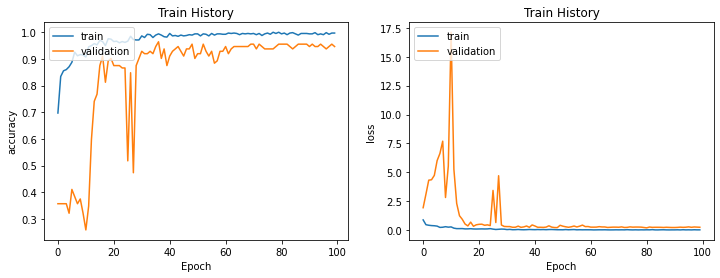

In [19]:
plot(history)

From the learning curve, the curve starts to converge around 15 epochs, but fluctuates more around 30 epochs until 40 epochs when it reaches a higher value and leveling off.
Compared with the resnext in the first experiment of the picture (200x200 picture size, 4 classification targets), the accuracy can rise smoothly without fluctuation, and after reaching convergence, there is no great fluctuation, but tends to be smooth

In [20]:
def get_newimage(image, resize_height=400, resize_width=400, normalization=True):
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 将BGR转为RGB
    rgb_image = cv2.resize(rgb_image, (resize_width, resize_height))
    rgb_image = np.asanyarray(rgb_image)
    if normalization:
        rgb_image = rgb_image / 255.
    rgb_image = rgb_image[np.newaxis, :]
    return rgb_image

In [21]:
class_list = ["EOS", "LYT", "MON", "NGS","BAS"]
labels = list()
preds = list()
predict_list = list()
test_path = '/content/drive/MyDrive/new_data_2/test'

model = load_model('/content/models/best_model_ResNext_2.h5')
#model.summary()

In [22]:
def get_files(path):
    file_list = []
    for maindir, subdir, file_name_list in os.walk(path):
        for filename in file_name_list:
            if ".tiff" in filename or ".jpg" in filename:
                apath = os.path.join(maindir,filename)
                file_list.append(apath)
    file_list.sort()
    return file_list

In [23]:
import numpy as np
all_files = get_files(test_path)
for file in all_files:
    print(file)
    label = int(file.split("/")[-2])
    labels.append(label-1)
    image = cv2.imread(file)
    res = model.predict(get_newimage(image))
    res = np.argmax(res)
    preds.append(res)
    if label-1 == res:
        predict_list.append(1)
    else:
        predict_list.append(0)

/content/drive/MyDrive/new_data_2/test/1/EOS_0072.tiff
/content/drive/MyDrive/new_data_2/test/1/EOS_0073.tiff
/content/drive/MyDrive/new_data_2/test/1/EOS_0074.tiff
/content/drive/MyDrive/new_data_2/test/1/EOS_0075.tiff
/content/drive/MyDrive/new_data_2/test/1/EOS_0076.tiff
/content/drive/MyDrive/new_data_2/test/1/EOS_0077.tiff
/content/drive/MyDrive/new_data_2/test/1/EOS_0078.tiff
/content/drive/MyDrive/new_data_2/test/1/EOS_0079.tiff
/content/drive/MyDrive/new_data_2/test/1/EOS_0080.tiff
/content/drive/MyDrive/new_data_2/test/1/EOS_0081.tiff
/content/drive/MyDrive/new_data_2/test/1/EOS_0082.tiff
/content/drive/MyDrive/new_data_2/test/1/EOS_0083.tiff
/content/drive/MyDrive/new_data_2/test/1/EOS_0096.tiff
/content/drive/MyDrive/new_data_2/test/1/EOS_0097.tiff
/content/drive/MyDrive/new_data_2/test/1/EOS_0098.tiff
/content/drive/MyDrive/new_data_2/test/1/EOS_0099.tiff
/content/drive/MyDrive/new_data_2/test/1/EOS_0100.tiff
/content/drive/MyDrive/new_data_2/test/1/EOS_0101.tiff
/content/d

In [24]:
print("Accuracy：",sum(predict_list)/len(predict_list))

Accuracy： 0.9495548961424333


In [25]:
from sklearn.metrics import confusion_matrix
C = confusion_matrix(labels, preds)
print(C)

[[ 35   0   0   0   0]
 [  0 113   4   3   0]
 [  0   2  67   0   1]
 [  0   0   0  87   2]
 [  1   2   0   2  18]]


In [26]:
import numpy as np
def plot_confusion_matrix(cm, classes, normalize, title):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    title_font = {'family': 'serif', 'color': 'black', 'weight': 'bold', 'size': 15}
    label_font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 10}
    plt.title(title, fontdict=title_font)
    plt.ylabel('True label',fontdict=label_font)
    plt.xlabel('Predicted label',fontdict=label_font)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.show()

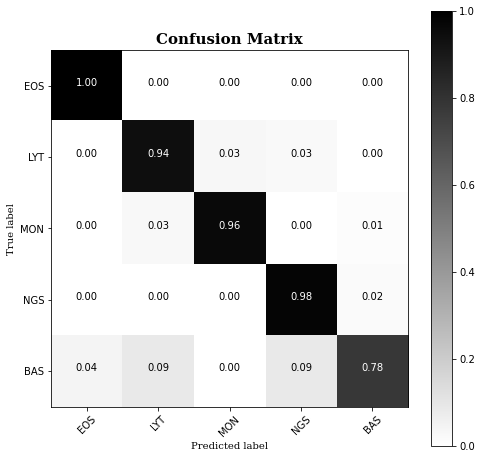

In [28]:
# Compute confusion matrix
import itertools   
cnf_matrix = confusion_matrix(labels, preds)
np.set_printoptions(precision=2)
label_names = ["EOS", "LYT", "MON", "NGS","BAS"]
# Plot normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=label_names, normalize=True, 
                      title='Confusion Matrix')

Although the overall accuracy is not as high as ResNext in the first experiment, considering the addition of an extra category and the increased resolution of the images, it can be seen from the confusion matrix above that there are more errors in the BAS category and more confusion with LYT and NGS, one reason being that BAS only has a smaller shu ju ji compared to other types of leukocytes